# 📖 Вовед 

Целта на овој проект е да се изгради модел на длабока невронска мрежа што ќе може прецизно да ги класифицира експресиите на лицето како што се: Лутина, Страв, Среќен, Тажен, Изненаден, Неутрален и Згаден. Во овој проект ќе користиме конволуциски невронски мрежи (CNN) за да го тренираме моделот, затоа што се најефективни кога станува збор за класифицирање на задачи поврзани со слики. За таа цел ќе се користи податочното множество FER-2013.



# 💾 Податоци

Податочното множество FER-2013 се состои од сиви слики на лица со 48х48 пиксели, кои се центрирани и окупираат ист простор во секоја слика. Податочното множество се состои од 24 илијади слики, со 22 илијади примери во тренирачкото множество и 1 илијада примери во тестирачкото множество.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, Flatten, Dense
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import joblib

In [2]:
train = pd.read_csv("data/train.csv")

print(f'Train Shape : {train.shape} /n')

train.info()

Train Shape : (28709, 2) /n
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


# 🔍Експлораторна Анализа

Text(0.5, 1.0, 'Counts')

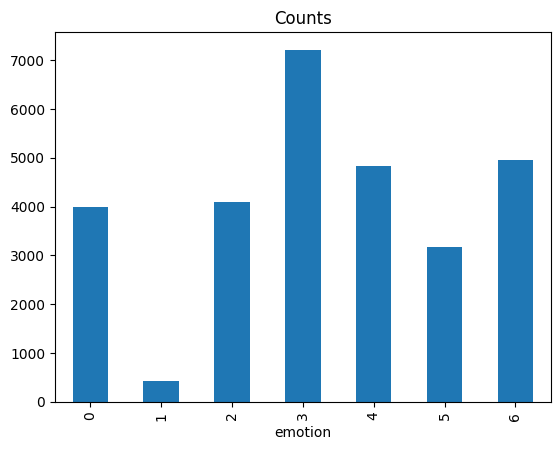

In [3]:
td = train["emotion"].value_counts().sort_index()
td.plot(kind='bar')
plt.title('Target Distribution')
plt.title('Emotion')
plt.title('Counts')

 We can see here that we don't have balance in the distribution of the data. We won't use accuracy to test our model, instead we'll use F1.

# 🛠 Претпроцесирање

In [4]:
def input_arrays(df,pixel_column):
    width = 48
    height = 48 
    image_arrays = []
    for pixel_string in df[pixel_column]:
        pixel_list = pixel_string.split()
        image_array = np.array(pixel_list,dtype=np.uint8).reshape(height,width,1)
        image_arrays.append(image_array)
    image_arrays = np.stack(image_arrays)
    image_arrays = image_arrays/255.0
    return image_arrays
lable_array = train['emotion'].to_numpy()
train_labels = lable_array.reshape(-1,1)
train_images = input_arrays(train,'pixels')
print(f'Train Images Shape: {train_images.shape}')
print(f'Train Lables Shape: {train_labels.shape}')

Train Images Shape: (28709, 48, 48, 1)
Train Lables Shape: (28709, 1)


## Viewing sample of images 

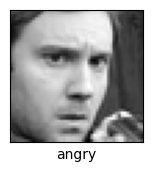

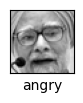

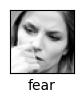

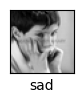

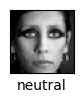

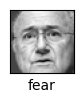

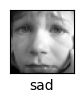

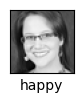

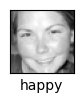

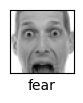

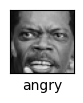

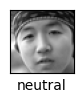

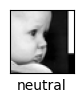

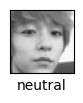

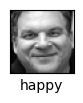

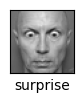

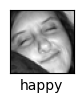

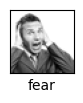

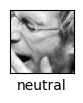

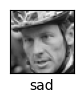

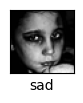

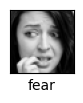

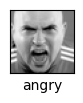

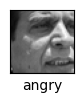

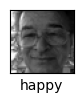

In [5]:
label_names = ['angry','disgust','fear','happy','sad','surprise','neutral']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap='gray')
    plt.xlabel(label_names[train_labels[i][0]])
    plt.show()

In [6]:
def random_oversampler(X,y):
    reshaped_X = X.reshape(X.shape[0],-1)
    ros = RandomOverSampler(random_state=0)
    X_ros, y_ros = ros.fit_resample(reshaped_X, y)
    X_ros = X_ros.reshape(-1,48,48,1)
    y_ros = y_ros.reshape(-1,1)
    return X_ros, y_ros

X_ros, y_ros = random_oversampler(train_images, train_labels)
print(f'Oversampled Train Images Shape:{X_ros.shape}')
print(f'Oversampled Train Lables Shape:{y_ros.shape}')
print(Counter(y_ros[:,0]))

Oversampled Train Images Shape:(50505, 48, 48, 1)
Oversampled Train Lables Shape:(50505, 1)
Counter({0: 7215, 2: 7215, 4: 7215, 6: 7215, 3: 7215, 5: 7215, 1: 7215})


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_ros,y_ros,test_size=0.2,random_state=42)
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X_ros,y_ros,test_size=0.3,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f'X_train Shape: {X_train.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_test Shape: {y_test.shape}')
print(f'X_val Shape: {X_val.shape}')
print(f'y_val Shape: {y_val.shape}')

X_train Shape: (40404, 48, 48, 1)
y_train Shape: (40404, 1)
X_test Shape: (7576, 48, 48, 1)
y_test Shape: (7576, 1)
X_val Shape: (7576, 48, 48, 1)
y_val Shape: (7576, 1)


In [7]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(48,48, 1)),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    BatchNormalization(),
    
    Flatten(),
    
    Dense(256,activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(7, activation=None)
])

cnn.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 24, 24, 32)        128       
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)              

In [8]:
opt = tf.keras.optimizers.Adam(0.001)
cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# Тренирање

In [38]:
%%time
history = cnn.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
1263/1263 [==============================] - 82s 63ms/step - loss: 4.0575 - accuracy: 0.1589 - val_loss: 2.5417 - val_accuracy: 0.1585
Epoch 2/100
1263/1263 [==============================] - 80s 64ms/step - loss: 2.5724 - accuracy: 0.1617 - val_loss: 2.2645 - val_accuracy: 0.1668
Epoch 3/100
1263/1263 [==============================] - 77s 61ms/step - loss: 2.4822 - accuracy: 0.1580 - val_loss: 2.2275 - val_accuracy: 0.1744
Epoch 4/100
1263/1263 [==============================] - 78s 62ms/step - loss: 2.4946 - accuracy: 0.1639 - val_loss: 2.1969 - val_accuracy: 0.1700
Epoch 5/100
1263/1263 [==============================] - 78s 62ms/step - loss: 2.5849 - accuracy: 0.1562 - val_loss: 2.1457 - val_accuracy: 0.1639
Epoch 6/100
1263/1263 [==============================] - 78s 61ms/step - loss: 2.3651 - accuracy: 0.1540 - val_loss: 2.1217 - val_accuracy: 0.1793
Epoch 7/100
1263/1263 [==============================] - 13920s 11s/step - loss: 2.1860 - accuracy: 0.1566 - val_loss:

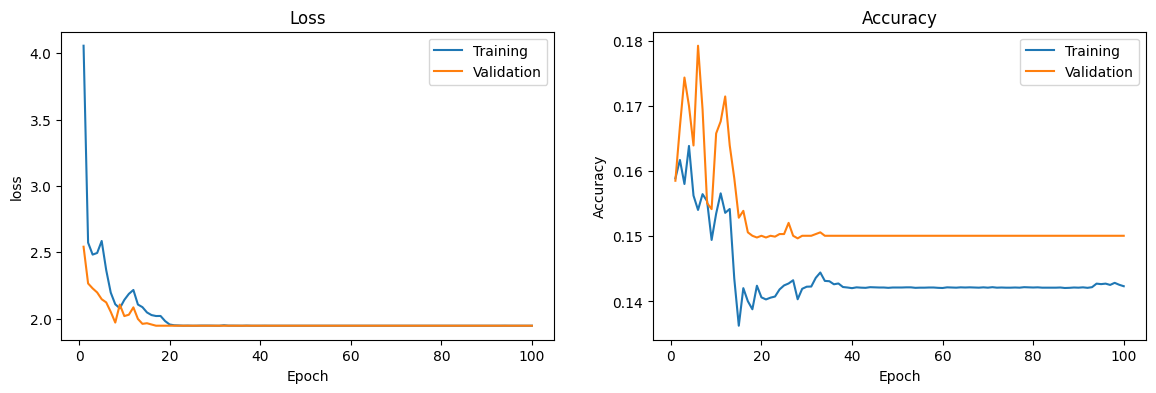

In [39]:
history = history.history
epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range,history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()

237/237 [==============================] - 2s 9ms/step


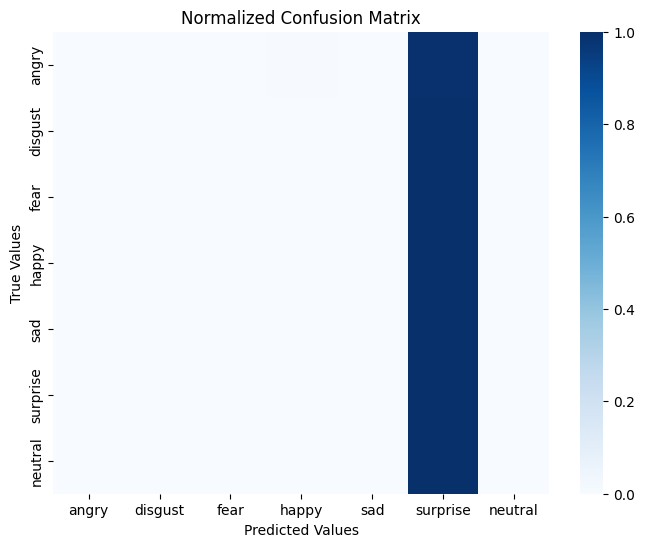

In [40]:
y_pred = np.argmax(cnn.predict(X_test), axis=-1)

cm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(cm, cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.title('Normalized Confusion Matrix')
plt.show()

In [41]:
cr = classification_report(y_test, y_pred, target_names=label_names)
print(cr)

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00      1119
     disgust       0.00      0.00      0.00      1079
        fear       0.00      0.00      0.00      1141
       happy       0.11      0.00      0.00      1056
         sad       0.00      0.00      0.00      1035
    surprise       0.14      1.00      0.24      1033
     neutral       0.00      0.00      0.00      1113

    accuracy                           0.14      7576
   macro avg       0.04      0.14      0.03      7576
weighted avg       0.03      0.14      0.03      7576



C:\Users\PC\OneDrive\Desktop\Machine Vision Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC\OneDrive\Desktop\Machine Vision Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC\OneDrive\Desktop\Machine Vision Project\venv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

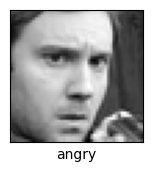

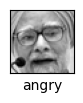

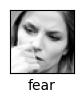

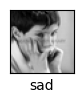

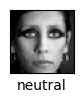

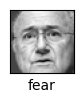

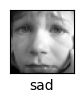

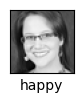

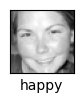

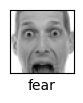

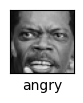

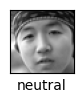

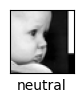

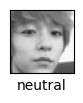

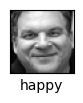

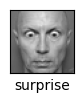

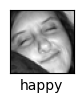

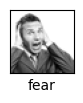

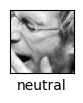

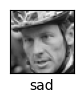

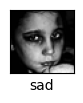

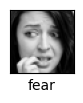

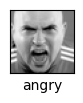

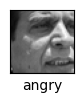

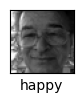

In [42]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i],cmap='gray')
    plt.xlabel(label_names[train_labels[i][0]])
    plt.show()

In [43]:
train_features = train_images.reshape(train_images.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

In [44]:
svm_classifier = SVC(kernel='linear')

In [45]:
y_train_flat = y_train.ravel()

In [46]:
svm_classifier.fit(X_train, y_train_flat)

SVC(kernel='linear')

In [47]:
y_pred = svm_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.33699059561128525


In [48]:
joblib.dump(svm_classifier, f'models/svm_cla

ssifier_model_{round(accuracy*100)}.pkl')

SyntaxError: unterminated string literal (detected at line 1) (2298255889.py, line 1)